In [251]:
%load_ext autoreload
%autoreload 2
# from trim import *
import matplotlib.pyplot as plt
import control
import scipy.linalg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Transport Aircraft Model
Pg 180 for dynamic equations

In [252]:
from transport import *

x = [250, 0, 0, 0, 750*0.3048, 0]   # 
u = [0, 0, 0.25, 1]                 # Landing configuration

In [253]:
res = trim(250,750,0,np.deg2rad(-2.5),land=1, gam_r=np.deg2rad(-3))
res


{'x0': array([ 2.50e+02,  3.82e-03, -3.98e-02,  0.00e+00,  7.50e+02,  0.00e+00]),
 'u0': array([  0.31, -15.22,   0.25,   1.  ,  -0.05]),
 's': array([ 3.09e-01, -1.52e+01,  3.82e-03])}

In [254]:
x_dot_check = longitudinal(res['x0'],res['u0'])
x_dot_check #Check for convergence, should be close to zero

SX([2.25785e-10, -1.96646e-08, 0, -1.97446e-09, -10.9048, 2.18163])

In [255]:
# res['u0']
#     thtl = u[0]
#     elev_deg = u[1]
#     xcg = u[2]
#     land = u[3]
#     gam_r = u[4]

In [256]:
sys = linearize(res)
np.set_printoptions(precision=3,linewidth=100)
sys['ss'].A # A matrix should matrix ap pg 335

array([[-3.858e-02,  1.898e+01, -3.214e+01,  0.000e+00,  1.325e-04,  0.000e+00],
       [-1.028e-03, -6.325e-01,  5.613e-03,  1.000e+00,  3.760e-06,  0.000e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  1.000e+00,  0.000e+00,  0.000e+00],
       [ 7.860e-05, -7.591e-01, -7.934e-04, -5.183e-01, -3.085e-07,  0.000e+00],
       [-4.362e-02, -2.498e+02,  2.498e+02,  0.000e+00,  0.000e+00,  0.000e+00],
       [ 8.727e-03, -2.500e+02,  2.500e+02,  0.000e+00,  0.000e+00,  0.000e+00]])

In [257]:
sys['ss'].B #Thrust and Elevator first 2 columns

array([[ 1.010e+01,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00],
       [-1.545e-04,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00],
       [ 2.466e-02, -1.077e-02,  6.856e-01,  0.000e+00,  0.000e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00, -2.500e+02]])

In [258]:
sys['ss'].C

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])

In [259]:
sys['ss'].D

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [260]:
sys['u0']

array([  0.309, -15.218,   0.25 ,   1.   ,  -0.052])

Controller Design for Automatic Landing

In [261]:
# Throttle-to-speed
G = get_tf(
    sys['ss'].A, sys['ss'].B,
    sys['ss'].C, sys['ss'].D,
    sys['u_id']['thrtl'], sys['y_id']['VT'])
G #This can vary depending on input and output
# This G is Vt/Thrtl transfer function should matches pg 337

TransferFunction(array([ 1.010e+01,  1.162e+01,  1.067e+01, -4.494e-01,  7.906e-03,  0.000e+00]), array([1.   , 1.189, 1.153, 0.058, 0.028, 0.   , 0.   ]))

In [262]:
# 336
# Look into obtaining throttle-to-speed based on CL block diagram to replace the new "sys" (operating_point)
def pitch_att(sys):
    cp = np.matrix([[0, 0, 57.29578, 0, 0, 0],[0,0,0,57.29578,0,0]])
    dp = np.matrix([0,0]).transpose()
    plant = control.ss(sys['ss'].A,np.matrix(sys['ss'].B[:,sys['u_id']['elev_deg']]).transpose(),cp,np.matrix(dp))
    actua = control.ss([-10],[10],[-1],[0])
    sys1 = control.series(actua,plant)
    # acl =sys1.A - sys1.B * [0, 1] * sys1.C
    acl = sys1. A- np.matrix(sys1.B * [0,1]) * sys1.C
    # display(acl)
    qclosed = control.ss(acl,sys1.B,sys1.C[0,:],0)
    lead = control.ss2tf([-14],[14],[-0.9],[1])
    sys2 = control.series(lead,qclosed)
    picomp=control.ss2tf([0],[0.2],[1],[1])
    sys3 = control.series(picomp,sys2)
    acl = sys3.A- sys3.B*40* sys3.C[0,:]

    cvt = np.zeros(9)
    cvt[0] = 1
    bth = np.append((sys['ss'].B[:, sys['u_id']['thrtl']]),[0,0,0])
    # display(acl,bth)
    np.set_printoptions(precision=2,linewidth=120)

    # display(control.ss2tf(acl,bth,cvt,0))
    ss = control.ss(acl,bth,cvt,0)

    x_id = {'VT': 0, 'alpha': 1, 'theta': 2, 'q': 3, 'h': 4, 'd': 5}
    y_id = {'VT': 0, 'alpha': 1, 'theta': 2, 'q': 3, 'h': 4, 'd': 5}
    u_id = {'thrtl': 0}
    return {
        'ss': ss,
        'x_id': x_id,
        'y_id': y_id,
        'u_id': u_id,
    }
    return ops

sys_new = pitch_att(sys) #get ss from this and input at operating points to simulate
# control.ss2tf(sys_new)

In [263]:
# pg 337 eqn 1
s = control.tf([1,0],[0,1])
tf= ( 10.10*(s+0.2736+0.1116*1j)*(s+0.2736-0.1116*1j)*(s+0.001484)  ) / ( (s+0.2674+0.1552*1j)*(s+0.2674-0.1552*1j)*(s+0.0002005)*(s+0.06449)   )
tf

TransferFunction(array([1.01e+01+0.00e+00j, 5.54e+00+0.00e+00j, 8.90e-01-5.55e-17j, 1.31e-03-8.24e-20j]), array([1.00e+00+0.j, 5.99e-01+0.j, 1.30e-01+0.j, 6.19e-03+0.j, 1.24e-06+0.j]))

In [264]:
picomp=control.ss2tf([0],[0.2],[1],[1])
picomp
H = 10 * (s+1)/(s+10) # G1 Compensator
display(control.series(picomp,H))
control.feedback(H*picomp)


TransferFunction(array([10., 12.,  2.]), array([ 1., 10.,  0.]))

TransferFunction(array([10., 12.,  2.]), array([11., 22.,  2.]))

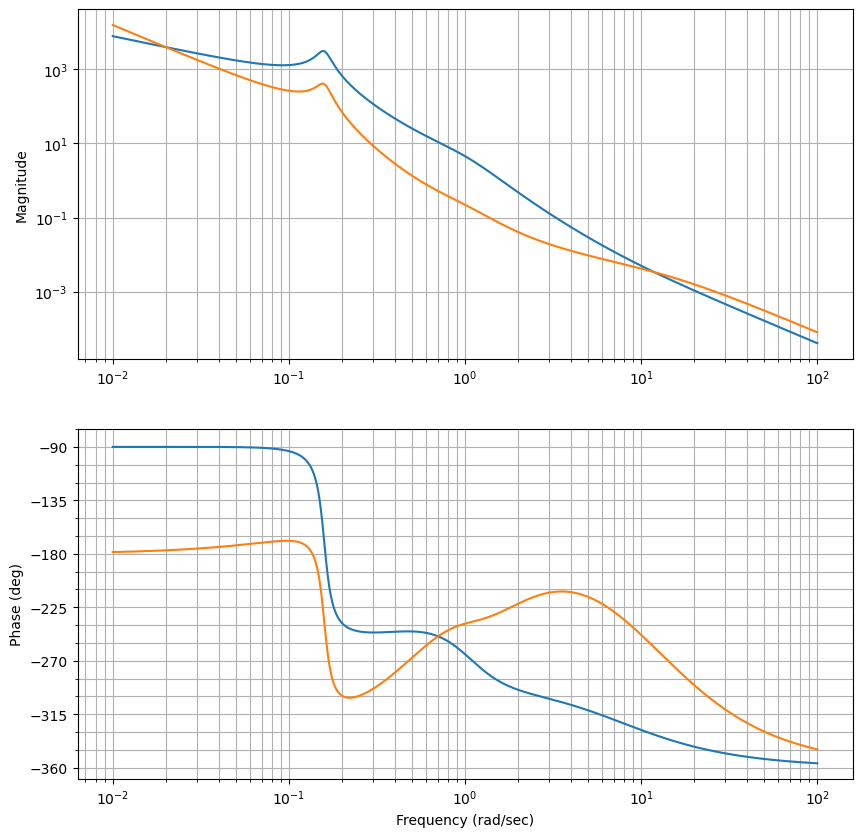

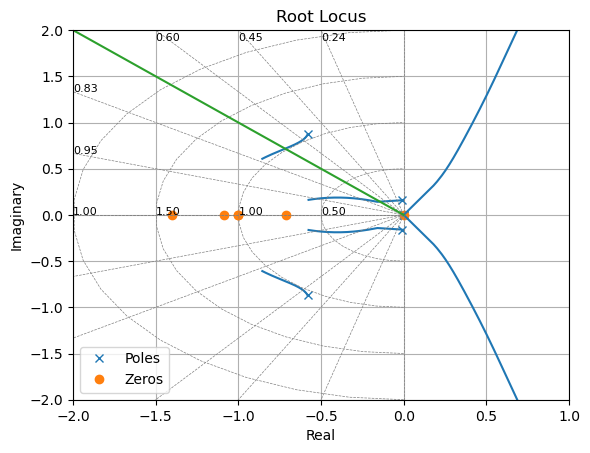

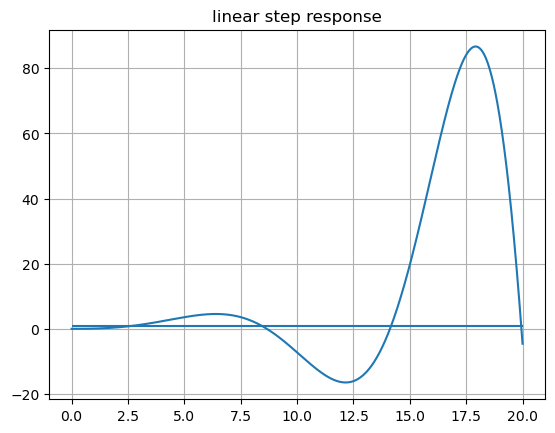

In [265]:
def control_design(operating_point):
    op = operating_point
    G = get_tf(
        op['ss'].A, op['ss'].B,
        op['ss'].C, op['ss'].D,
        op['u_id']['thrtl'], op['y_id']['h'])

    s = control.tf([1, 0], [0, 1])
    # H = 0.1*(20*(s+1)/(s+20))**3   #-0.17*(s+1)**3*(20/(s+20))**3
    H = 10 * (s+1)/(s+10) # G1 Compensator
    picomp=control.ss2tf([0],[0.2],[1],[0.2])
    lead = control.ss2tf([-14],[14],[-0.9],[1])
    H = control.series(lead,picomp, 10 * (s+1)/((s+10))) # G1 compensator + PI CL feedback
    plt.figure(figsize=(10, 10))
    control.bode([G, G*H]);

    plt.figure()
    control.rlocus(G*H, xlim=[-2, 1], ylim=[-2, 2], kvect=np.linspace(0, 100, 1000));
    plt.plot([0, -10], [0, 10])
    plt.grid()
    plt.legend(['Poles','Zeros'])
    
    plt.figure()
    t, y = control.step_response(control.feedback(G*H),
    T = np.linspace(0, 20, 1000))
    plt.hlines(1, t[0], t[-1])
    plt.plot(t, y)
    plt.grid()
    plt.title('linear step response')

    return {
        'H': H
    }

control_data = control_design(sys)

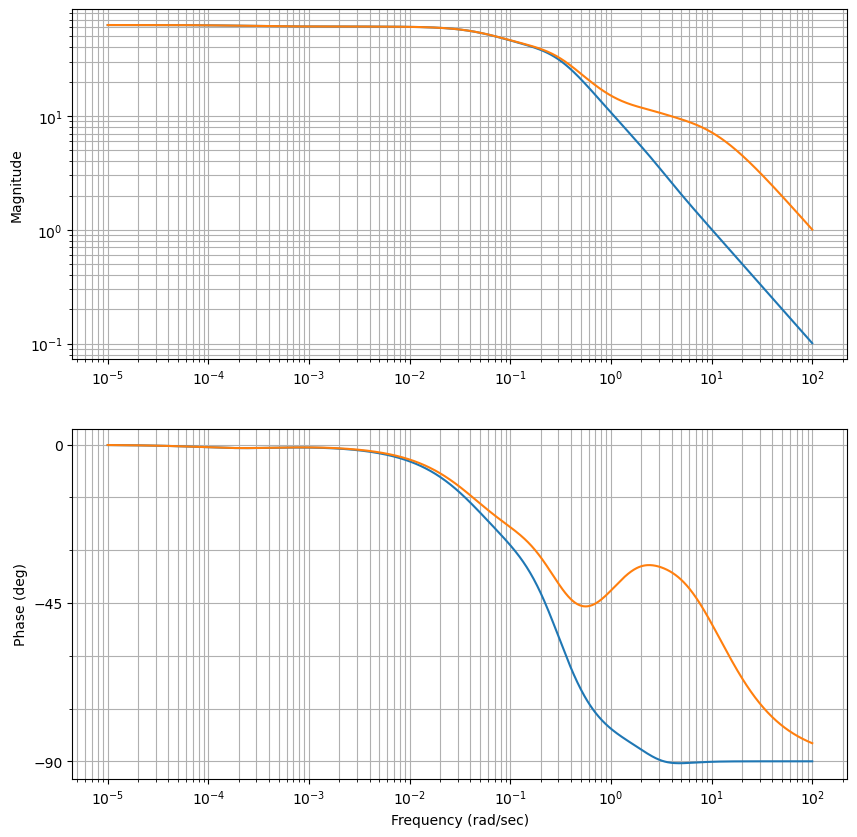

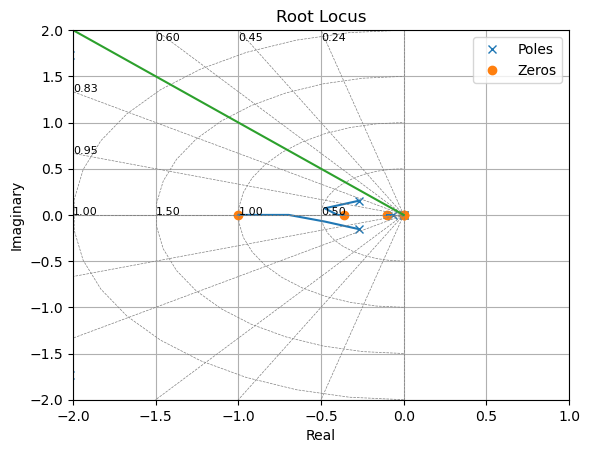

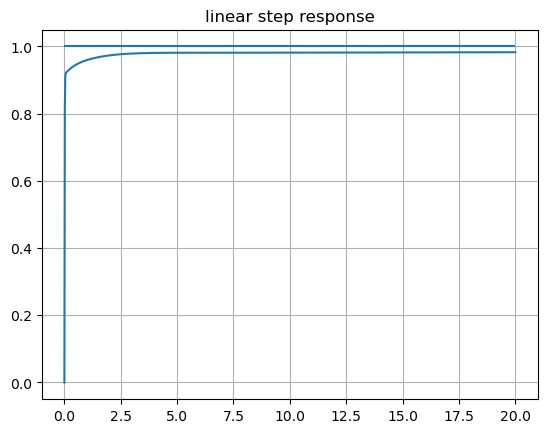

In [266]:
#Throttle-to-speed control design
def control_design(operating_point):
    op = operating_point
    G = get_tf(
        op['ss'].A, op['ss'].B,
        op['ss'].C, op['ss'].D,
        op['u_id']['thrtl'], op['y_id']['VT'])

    s = control.tf([1, 0], [0, 1])
    # H = 0.1*(20*(s+1)/(s+20))**3   #-0.17*(s+1)**3*(20/(s+20))**3
    H = 10 * (s+1)/(s+10) # G1 Compensator
    picomp=control.ss2tf([0],[0.2],[1],[0.2])
    # lead = control.ss2tf([-14],[14],[-0.9],[1])
    H = ( 10 * (s+1)/((s+10))) #*picomp # G1 compensator +PI
    plt.figure(figsize=(10, 10))
    control.bode([G, G*H]);

    plt.figure()
    control.rlocus(G*H, xlim=[-2, 1], ylim=[-2, 2], kvect=np.linspace(0, 100, 1000));
    plt.plot([0, -10], [0, 10])
    plt.grid()
    plt.legend(['Poles','Zeros'])
    
    plt.figure()
    t, y = control.step_response(control.feedback(G*H),
    T = np.linspace(0, 20, 1000))
    plt.hlines(1, t[0], t[-1])
    plt.plot(t, y)
    plt.grid()
    plt.title('linear step response')

    return {
        'H': H
    }

control_data_thrtl = control_design(sys_new)

In [273]:
# Design System for Speed control loop [NEED REVIEW]
# 336
# Look into obtaining throttle-to-speed based on CL block diagram to replace the new "sys" (operating_point)
def speed_loop_sys(sys):
    cp = np.matrix([[0, 0, 57.29578, 0, 0, 0],[0,0,0,57.29578,0,0]])
    dp = np.matrix([0,0]).transpose()
    plant = control.ss(sys['ss'].A,np.matrix(sys['ss'].B[:,sys['u_id']['elev_deg']]).transpose(),cp,np.matrix(dp))
    actua = control.ss([-10],[10],[-1],[0])
    sys1 = control.series(actua,plant)
    # acl =sys1.A - sys1.B * [0, 1] * sys1.C
    acl = sys1. A- np.matrix(sys1.B * [0,1]) * sys1.C
    # display(acl)
    qclosed = control.ss(acl,sys1.B,sys1.C[0,:],0)
    lead = control.ss2tf([-14],[14],[-0.9],[1])
    sys2 = control.series(lead,qclosed)
    picomp=control.ss2tf([0],[0.2],[1],[1])
    sys3 = control.series(picomp,sys2)
    acl = sys3.A- sys3.B*40* sys3.C[0,:]

    cvt = np.zeros(9)
    cvt[0] = 1
    bth = np.append((sys['ss'].B[:, sys['u_id']['thrtl']]),[0,0,0])
    # display(acl,bth)
    np.set_printoptions(precision=2,linewidth=120)

    # display(control.ss2tf(acl,bth,cvt,0))
    th2vt = control.ss(acl,bth,cvt,0)
    servo = control.ss([-0.2],[0.2],[1],[0])
    ut2vt = control.series(servo,th2vt)
    splead = control.ss([-10],[10],[-0.9],[1])
    compsp = control.series(splead,ut2vt)
    acl = compsp.A - compsp.B * 10 * compsp.C

    btheta = np.append(40*sys3.B[:,0],[0,0])#.transpose()
    cd = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0 ]
    ss = control.ss(acl,np.matrix(btheta).transpose(),cd,0)

    x_id = {'VT': 0, 'alpha': 1, 'theta': 2, 'q': 3, 'h': 4, 'd': 5}
    y_id = {'VT': 0, 'alpha': 1, 'theta': 2, 'q': 3, 'h': 4, 'd': 5}
    u_id = {'elev_deg': 0}
    return {
        'ss': ss,
        'x_id': x_id,
        'y_id': y_id,
        'u_id': u_id,
    }
    return ops

sys_sp = speed_loop_sys(sys) #get ss from this and input at operating points to simulate
control.ss2tf(sys_sp['ss'])


TransferFunction(array([-4.97e-14,  9.86e-01,  1.48e+01, -9.98e+01, -1.85e+03, -9.57e+03, -2.20e+04, -2.19e+04, -6.81e+03, -6.67e+00,
        0.00e+00]), array([1.00e+00, 3.54e+01, 4.55e+02, 2.90e+03, 1.06e+04, 2.37e+04, 3.08e+04, 2.14e+04, 5.71e+03, 3.85e+02, 7.93e-02,
       0.00e+00]))

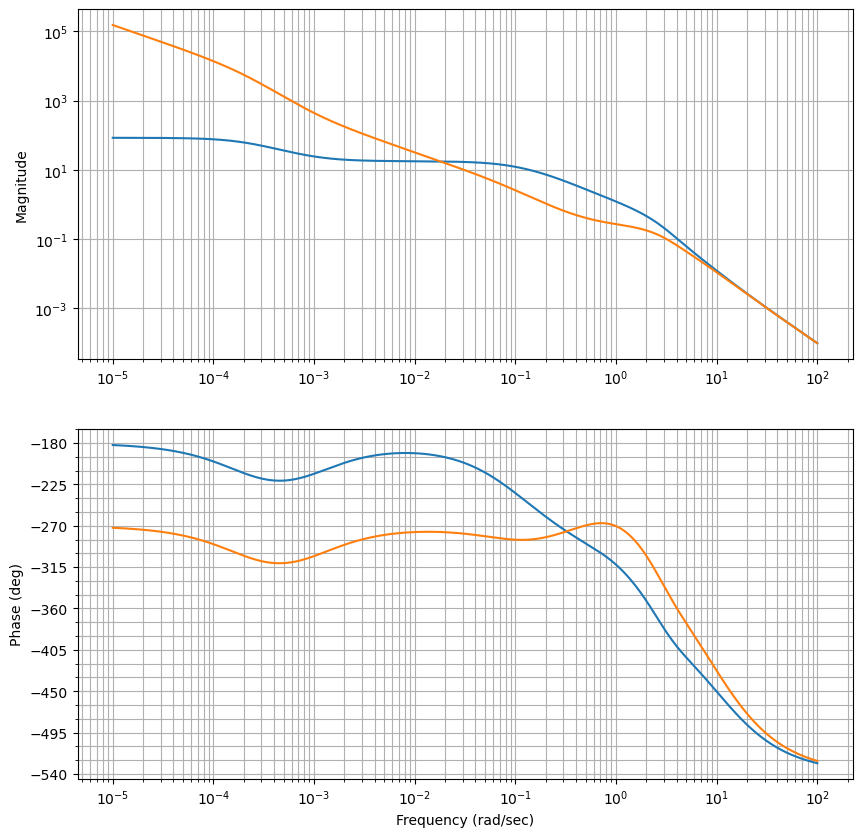

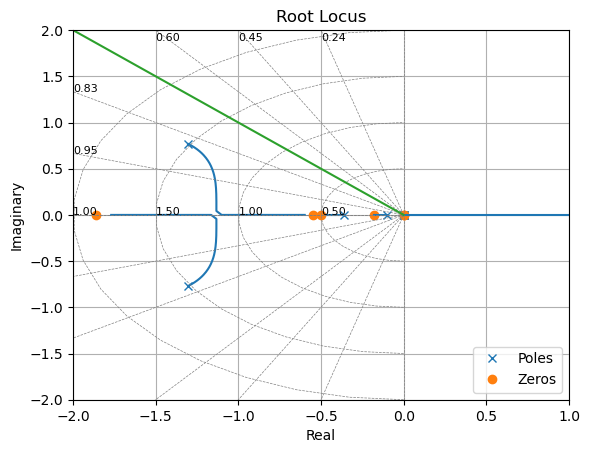

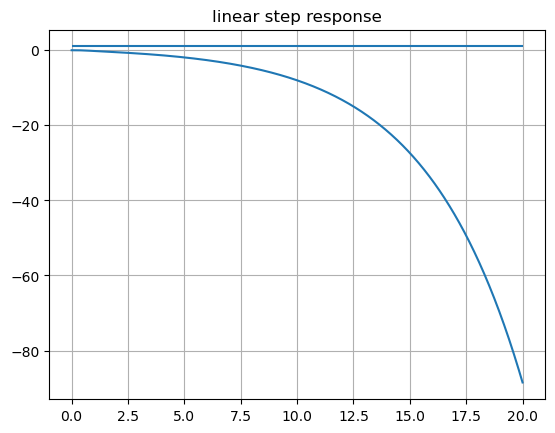

In [268]:
# speed control loop
def control_design(operating_point):
    op = operating_point
    G = get_tf(
        op['ss'].A, op['ss'].B,
        op['ss'].C, op['ss'].D,
        op['u_id']['thrtl'], op['y_id']['VT'])

    s = control.tf([1, 0], [0, 1])
    # picomp=control.ss2tf([0],[0.2],[1],[0.2])
    # lead = control.ss2tf([-14],[14],[-0.9],[1])
    H = 1.0 * ( (s+0.18)*(s+0.5) )/ ( s*(s+5)) # G2 compensator 
    plt.figure(figsize=(10, 10))
    control.bode([G, G*H]);

    plt.figure()
    control.rlocus(G*H, xlim=[-2, 1], ylim=[-2, 2], kvect=np.linspace(0, 100, 1000));
    plt.plot([0, -10], [0, 10])
    plt.grid()
    plt.legend(['Poles','Zeros'])
    
    plt.figure()
    t, y = control.step_response(control.feedback(G*H),
    T = np.linspace(0, 20, 1000))
    plt.hlines(1, t[0], t[-1])
    plt.plot(t, y)
    plt.grid()
    plt.title('linear step response')

    return {
        'H': H
    }

control_data_speed = control_design(sys_sp)

In [269]:
# # elevator-to-d transfer function
# G2 = get_tf(
#     sys['ss'].A, sys['ss'].B,
#     sys['ss'].C, sys['ss'].D,
#     sys['u_id']['elev_deg'], sys['y_id']['d'])
# G2 #This can vary depending on input and output

Discrete-Time simulations

In [270]:
from discrete_ss_sim import *
# Base system simulate
# data = simulate(control_data, sys)
# ''' Implement controller through control_data['H'] and parsing in continuous time transfer function'''
# plt.figure()
# plt.plot(data['t'], data['VT'][:,0,0], label='VT');
# plt.legend(loc='best')
# plt.grid()

# plt.figure()
# plt.plot(data['t'], data['h'][:,0,0], label='h');
# plt.legend(loc='best')
# plt.grid()


# plt.figure()
# plt.plot(data['t'], data['d'][:,0,0], label='d');
# plt.legend(loc='best')
# plt.grid()

x0 [ 2.50e+02  3.82e-03 -3.98e-02  0.00e+00  7.50e+02  0.00e+00]
u0 [  0.31 -15.22   0.25   1.    -0.05]


/tmp/ipykernel_379129/2850183442.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[u_id['thrtl']]+= controller_speed.update(v_error)
/tmp/ipykernel_379129/2850183442.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[u_id['elev_deg']] += controller_thrtl.update(h_error) #or h_error


[187.338, -1.49544, -263.805, -7.31159, 271.806, -407.032]


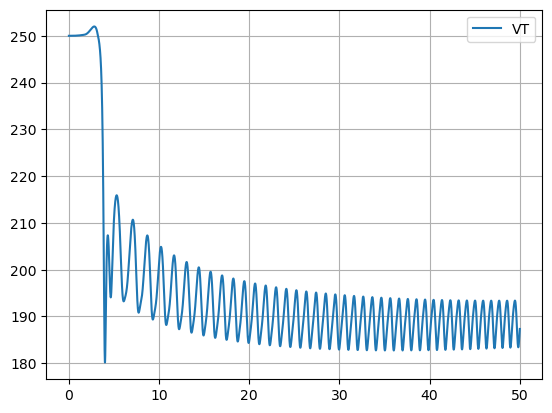

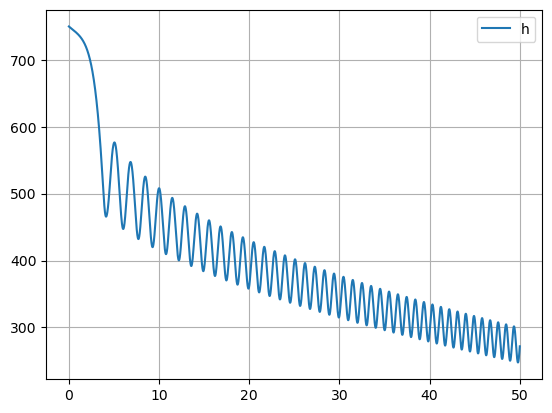

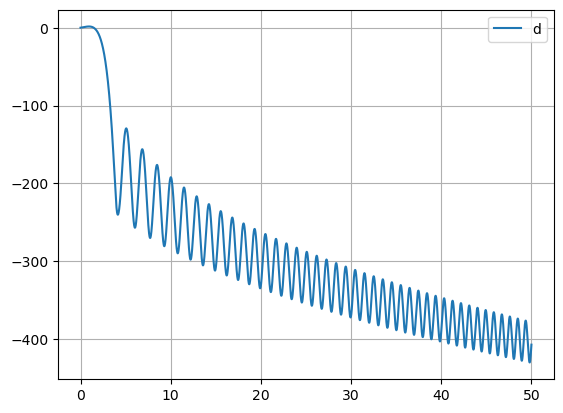

In [271]:
# Simulate Landing
def simulate_landing(control_data_thrtl,control_data_speed, operating_point):
    ''' 
    Simulate Discrete Time State Space problem
    Accepts input of control transfer function (H) and linearized operating point
    '''
    op = operating_point
    x_id = op['x_id']
    y_id = op['y_id']
    u_id = op['u_id']

    # Control Functions
    H_th = control_data_thrtl['H']
    H_sp = control_data_speed['H']

    x_sym = ca.SX.sym('x', 6, 1)
    u_sym = ca.SX.sym('u', 4, 1)
    dt = 0.01
    controller_thrtl = DiscreteStateSpace(H_th, dt)
    controller_speed = DiscreteStateSpace(H_sp, dt)

    # Construct a Function that integrates over 4s
    x = op['x0']
    print('x0', op['x0'])
    print('u0', op['u0'])
    h = []
    data = {
        'VT': [],
        'alpha': [],
        'theta': [],
        'q': [],
        'h': [],
        'd': [],
        't': [],
    }
    t = 0
    tf = 50 # set final time
    h_desired = 750 #desired h 200
    v_desired = 250 #desired h 500
    d_desired = 0 #desired d
    while t < tf:
        h_error = h_desired - x[x_id['h']]
        v_error = v_desired - x[y_id['VT']] #speed error
        d_error = d_desired - x[y_id['d']] #d-loop error
        u = np.array(op['u0'])
        # u[u_id['thrtl']] += 1*h_error #or h error
        # u[u_id['thrtl']] += controller.update(h_error) #or h_error
        u[u_id['thrtl']]+= 1*v_error
        u[u_id['thrtl']]+= controller_speed.update(v_error)
        u[u_id['elev_deg']] += 1*h_error #or h error
        u[u_id['elev_deg']] += controller_thrtl.update(h_error) #or h_error
        # u[u_id['thrtl']]+= 1*v_error
        # u[u_id['thrtl']]+= controller.update(v_error)
        
        F = ca.integrator('F','cvodes',{
            'x': x_sym, 'ode': longitudinal(x_sym, u)},{'tf': dt})
        res = F(x0=x)
        x = res['xf']
        data['VT'].append(x[x_id['VT']])
        data['alpha'].append(x[x_id['alpha']])
        data['theta'].append(x[x_id['theta']])
        data['q'].append(x[x_id['q']])
        data['h'].append(x[x_id['h']])
        data['d'].append(x[x_id['d']])
        data['t'].append(t)
        t += dt
    for k in data.keys():
        data[k] = np.array(data[k])
    print(x)
    return data

data = simulate_landing(control_data_thrtl,control_data_speed, sys)
''' Implement controller through control_data['H'] and parsing in continuous time transfer function'''
plt.figure()
plt.plot(data['t'], data['VT'][:,0,0], label='VT');
plt.legend(loc='best')
plt.grid()

plt.figure()
plt.plot(data['t'], data['h'][:,0,0], label='h');
plt.legend(loc='best')
plt.grid()


plt.figure()
plt.plot(data['t'], data['d'][:,0,0], label='d');
plt.legend(loc='best')
plt.grid()